In [1]:
# The next library we're going to look at is called Kraken, which was developed by Université 
# PSL in Paris. It's actually based on a slightly older code base, OCRopus. You can see how the
# flexible open-source licenses allow new ideas to grow by building upon older ideas. And, in
# this case, I fully support the idea that the Kraken - a mythical massive sea creature - is the
# natural progression of an octopus!
#
# What we are going to use Kraken for is to detect lines of text as bounding boxes in a given
# image. The biggest limitation of tesseract is the lack of a layout engine inside of it. Tesseract
# expects to be using fairly clean text, and gets confused if we don't crop out other artifacts.
# It's not bad, but Kraken can help us out be segmenting pages. Lets take a look.

In [2]:
# First, we'll take a look at the kraken module itself
import kraken
help(kraken)

Help on package kraken:

NAME
    kraken - entry point for kraken functionality

PACKAGE CONTENTS
    binarization
    ketos
    kraken
    lib (package)
    linegen
    pageseg
    repo
    rpred
    serialization
    transcribe

DATA
    absolute_import = _Feature((2, 5, 0, 'alpha', 1), (3, 0, 0, 'alpha', 0...
    division = _Feature((2, 2, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0), 8192...
    print_function = _Feature((2, 6, 0, 'alpha', 2), (3, 0, 0, 'alpha', 0)...

FILE
    /Users/tlombard/Desktop/venvPY3/lib/python3.7/site-packages/kraken/__init__.py




In [3]:
# There isn't much of a discussion here, but there are a number of sub-modules that look
# interesting. I spend a bit of time on their website, and I think the pageseg module, which
# handles all of the page segmentation, is the one we want to use. Lets look at it
from kraken import pageseg
help(pageseg)

Help on module kraken.pageseg in kraken:

NAME
    kraken.pageseg

DESCRIPTION
    kraken.pageseg
    ~~~~~~~~~~~~~~
    
    Layout analysis and script detection methods.

FUNCTIONS
    detect_scripts(im, bounds, model='/Users/tlombard/Desktop/venvPY3/lib/python3.7/site-packages/kraken/script.mlmodel', valid_scripts=None)
        Detects scripts in a segmented page.
        
        Classifies lines returned by the page segmenter into runs of scripts/writing systems.
        
        Args:
            im (PIL.Image): A bi-level page of mode '1' or 'L'
            bounds (dict): A dictionary containing a 'boxes' entry with a list of
                           coordinates (x0, y0, x1, y1) of a text line in the image
                           and an entry 'text_direction' containing
                           'horizontal-lr/rl/vertical-lr/rl'.
            model (str): Location of the script classification model or None for default.
            valid_scripts (list): List of valid scripts

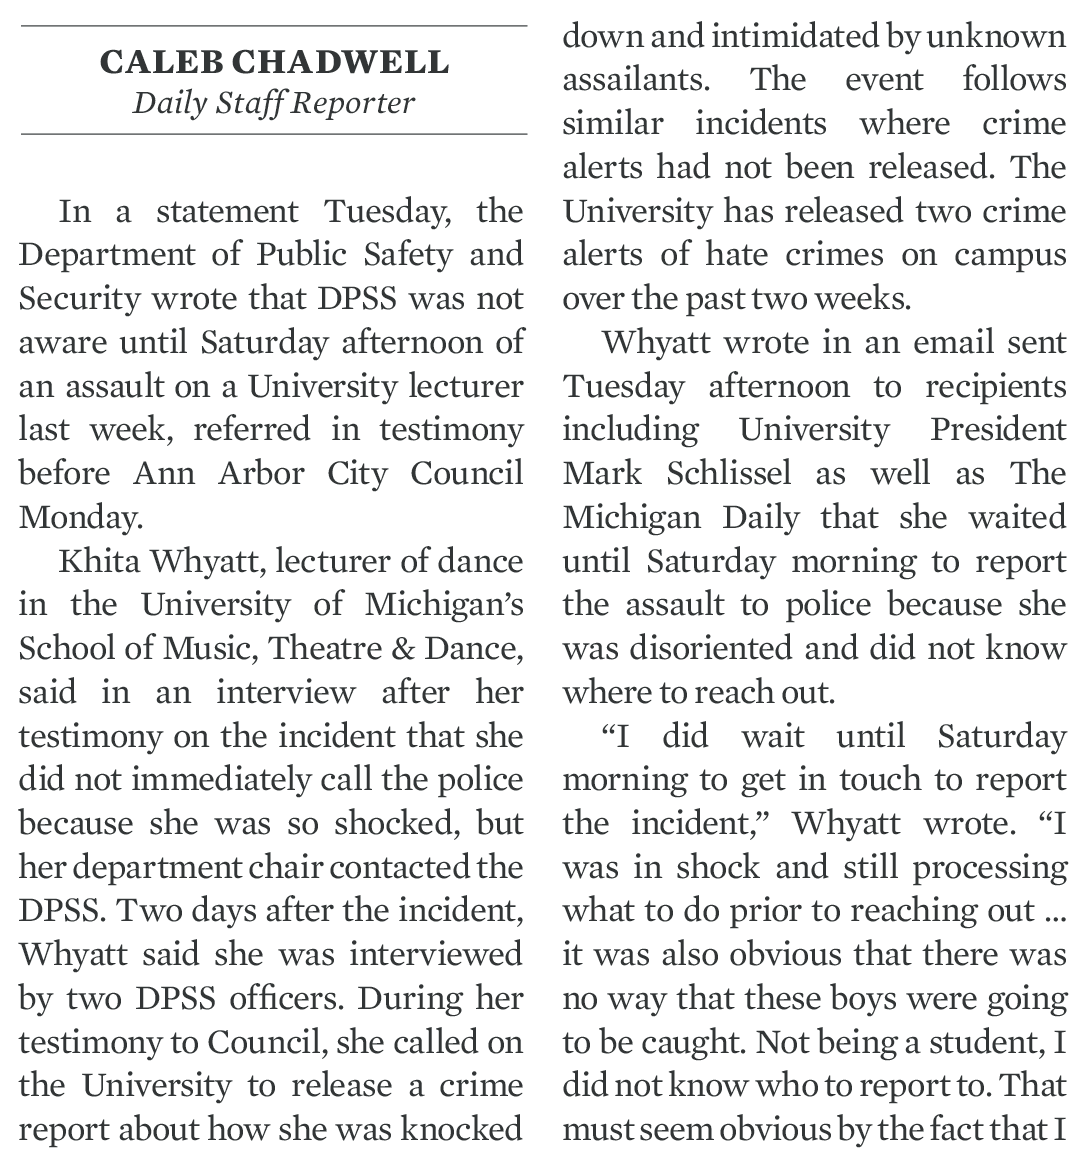

[[100, 50, 449, 74], [131, 88, 414, 120], [59, 196, 522, 229], [18, 239, 522, 272], [19, 283, 522, 316], [19, 327, 525, 360], [19, 371, 523, 404], [18, 414, 524, 447], [17, 458, 522, 491], [19, 502, 141, 535], [58, 546, 521, 579], [18, 589, 522, 622], [19, 633, 521, 665], [563, 21, 1066, 54], [564, 64, 1066, 91], [563, 108, 1066, 135], [564, 152, 1065, 179], [563, 196, 1065, 229], [563, 239, 1066, 272], [562, 283, 909, 316], [600, 327, 1066, 360], [562, 371, 1066, 404], [562, 414, 1066, 447], [563, 458, 1065, 485], [563, 502, 1065, 535], [562, 546, 1066, 579], [562, 589, 1064, 622], [562, 633, 1066, 660], [18, 677, 833, 704], [18, 721, 1066, 754], [18, 764, 1065, 797], [17, 808, 1065, 841], [18, 852, 1067, 885], [18, 895, 1065, 928], [17, 939, 1065, 972], [17, 983, 1067, 1016], [18, 1027, 1065, 1060], [18, 1070, 1065, 1103], [18, 1114, 1065, 1147]]


In [4]:
# So it looks like there are a few different functions we can call, and the segment
# function looks particularly appropriate. I love how expressive this library is on the
# documentation front -- I can see immediately that we are working with PIL.Image files,
# and the author has even indicated that we need to pass in either a binarized (e.g. '1')
# or grayscale (e.g. 'L') image. We can also see that the return value is a dictionary
# object with two keys, "text_direction" which will return to us a string of the
# direction of the text, and "boxes" which appears to be a list of tuples, where each
# tuple is a box in the original image.
#
# Lets try this on the image of text. I have a simple bit of text in a file called
# two_col.png which is from a newspaper on campus here
from PIL import Image
im=Image.open("readonly/two_col.png")
# Lets display the image inline
display(im)
# Lets now convert it to black and white and segment it up into lines with kraken
bounding_boxes=pageseg.segment(im.convert('1'))['boxes']
# And lets print those lines to the screen
print(bounding_boxes)

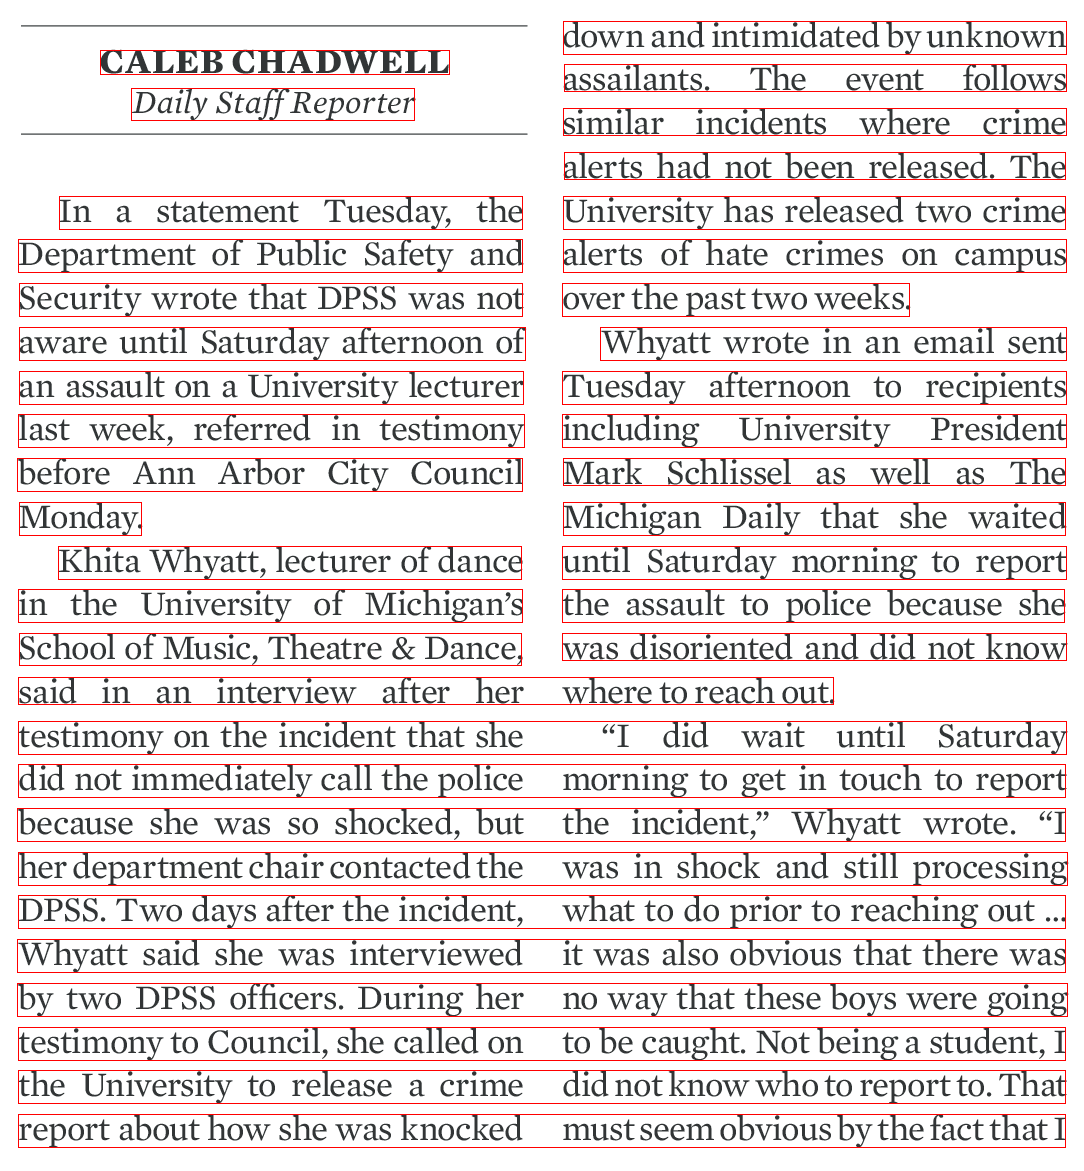

In [5]:
# Ok, pretty simple two column text and then a list of lists which are the bounding boxes of 
# lines of that text. Lets write a little routine to try and see the effects a bit more
# clearly. I'm going to clean up my act a bit and write real documentation too, it's a good
# practice
def show_boxes(img):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    # Lets bring in our ImageDraw object
    from PIL import ImageDraw
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(img)
    # We can create a set of boxes using pageseg.segment
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    # Now lets go through the list of bounding boxes
    for box in bounding_boxes:
        # An just draw a nice rectangle
        drawing_object.rectangle(box, fill = None, outline ='red')
    # And to make it easy, lets return the image object
    return img

# To test this, lets use display
display(show_boxes(Image.open("readonly/two_col.png")))

In [6]:
# Not bad at all! It's interesting to see that kraken isn't completely sure what to do with this
# two column format. In some cases, kraken has identified a line in just a single column, while
# in other cases kraken has spanned the line marker all the way across the page. Does this matter?
# Well, it really depends on our goal. In this case, I want to see if we can improve a bit on this.
#
# So we're going to go a bit off script here. While this week of lectures is about libraries, the
# goal of this last course is to give you confidence that you can apply your knowledge to actual
# programming tasks, even if the library you are using doesn't quite do what you want. 
#
# I'd like to pause the video for the moment and collect your thoughts. Looking at the image above,
# with the two column example and red boxes, how do you think we might modify this image to improve
# kraken's ability to text lines?

In [14]:
# Thanks for sharing your thoughts, I'm looking forward to seeing the breadth of ideas that everyone
# in the course comes up with. Here's my partial solution -- while looking through the kraken docs on 
# the pageseg() function I saw that there are a few parameters we can supply in order to improve 
# segmentation. One of these is the black_colseps parameter. If set to True, kraken will assume that 
# columns will be separated by black lines. This isn't our case here, but, I think we have all of the
# tools to go through and actually change the source image to have a black separator between columns.
#
# The first step is that I want to update the show_boxes() function. I'm just going to do a quick
# copy and paste from the above but add in the black_colseps=True parameter
def show_boxes(img):
    '''Modifies the passed image to show a series of bounding boxes on an image as run by kraken
    
    :param img: A PIL.Image object
    :return img: The modified PIL.Image object
    '''
    # Lets bring in our ImageDraw object
    from PIL import ImageDraw
    # And grab a drawing object to annotate that image
    drawing_object=ImageDraw.Draw(img)
    # We can create a set of boxes using pageseg.segment
    bounding_boxes=pageseg.segment(img.convert('1'), black_colseps=True)['boxes']
    # Now lets go through the list of bounding boxes
    for box in bounding_boxes:
        # An just draw a nice rectangle
        drawing_object.rectangle(box, fill = None, outline ='red')
    # And to make it easy, lets return the image object
    return img

In [15]:
# The next step is to think of the algorithm we want to apply to detect a white column separator.
# In experimenting a bit I decided that I only wanted to add the separator if the space of was
# at least 25 pixels wide, which is roughly the width of a character, and six lines high. The
# width is easy, lets just make a variable
char_width=25
# The height is harder, since it depends on the height of the text. I'm going to write a routine
# to calculate the average height of a line
def calculate_line_height(img):
    '''Calculates the average height of a line from a given image
    :param img: A PIL.Image object
    :return: The average line height in pixels
    '''
    # Lets get a list of bounding boxes for this image
    bounding_boxes=pageseg.segment(img.convert('1'))['boxes']
    # Each box is a tuple of (top, left, bottom, right) so the height is just top - bottom
    # So lets just calculate this over the set of all boxes
    height_accumulator=0
    for box in bounding_boxes:
        height_accumulator=height_accumulator+box[3]-box[1]
        # this is a bit tricky, remember that we start counting at the upper left corner in PIL!
    # now lets just return the average height
    # lets change it to the nearest full pixel by making it an integer
    return int(height_accumulator/len(bounding_boxes))

# And lets test this with the image with have been using
line_height=calculate_line_height(Image.open("readonly/two_col.png"))
print(line_height)

31


In [16]:
# Ok, so the average height of a line is 31.
# Now, we want to scan through the image - looking at each pixel in turn - to determine if there
# is a block of whitespace. How bit of a block should we look for? That's a bit more of an art
# than a science. Looking at our sample image, I'm going to say an appropriate block should be
# one char_width wide, and six line_heights tall. But, I honestly just made this up by eyeballing
# the image, so I would encourage you to play with values as you explore.
# Lets create a new box called gap box that represents this area
gap_box=(0,0,char_width,line_height*6)
gap_box

(0, 0, 25, 186)

In [17]:
# It seems we will want to have a function which, given a pixel in an image, can check to see
# if that pixel has whitespace to the right and below it. Essentially, we want to test to see
# if the pixel is the upper left corner of something that looks like the gap_box. If so, then
# we should insert a line to "break up" this box before sending to kraken
#
# Lets call this new function gap_check
def gap_check(img, location):
    '''Checks the img in a given (x,y) location to see if it fits the description
    of a gap_box
    :param img: A PIL.Image file
    :param location: A tuple (x,y) which is a pixel location in that image
    :return: True if that fits the definition of a gap_box, otherwise False
    '''
    # Recall that we can get a pixel using the img.getpixel() function. It returns this value
    # as a tuple of integers, one for each color channel. Our tools all work with binarized
    # images (black and white), so we should just get one value. If the value is 0 it's a black
    # pixel, if it's white then the value should be 255
    #
    # We're going to assume that the image is in the correct mode already, e.g. it has been
    # binarized. The algorithm to check our bounding box is fairly easy: we have a single location 
    # which is our start and then we want to check all the pixels to the right of that location 
    # up to gap_box[2]
    for x in range(location[0], location[0]+gap_box[2]):
        # the height is similar, so lets iterate a y variable to gap_box[3]
        for y in range(location[1], location[1]+gap_box[3]):
            # we want to check if the pixel is white, but only if we are still within the image
            if x < img.width and y < img.height:
                # if the pixel is white we don't do anything, if it's black, we just want to
                # finish and return False
                if img.getpixel((x,y)) != 255:
                    return False
    # If we have managed to walk all through the gap_box without finding any non-white pixels
    # then we can return true -- this is a gap!
    return True

In [13]:
# Alright, we have a function to check for a gap, called gap_check. What should we do once
# we find a gap? For this, lets just draw a line in the middle of it. Lets create a new function
def draw_sep(img,location):
    '''Draws a line in img in the middle of the gap discovered at location. Note that
    this doesn't draw the line in location, but draws it at the middle of a gap_box
    starting at location.
    :param img: A PIL.Image file
    :param location: A tuple(x,y) which is a pixel location in the image
    '''
    # First lets bring in all of our drawing code
    from PIL import ImageDraw
    drawing_object=ImageDraw.Draw(img)
    # next, lets decide what the middle means in terms of coordinates in the image
    x1=location[0]+int(gap_box[2]/2)
    # and our x2 is just the same thing, since this is a one pixel vertical line
    x2=x1
    # our starting y coordinate is just the y coordinate which was passed in, the top of the box
    y1=location[1]
    # but we want our final y coordinate to be the bottom of the box
    y2=y1+gap_box[3]
    drawing_object.rectangle((x1,y1,x2,y2), fill = 'black', outline ='black')
    # and we don't have anything we need to return from this, because we modified the image

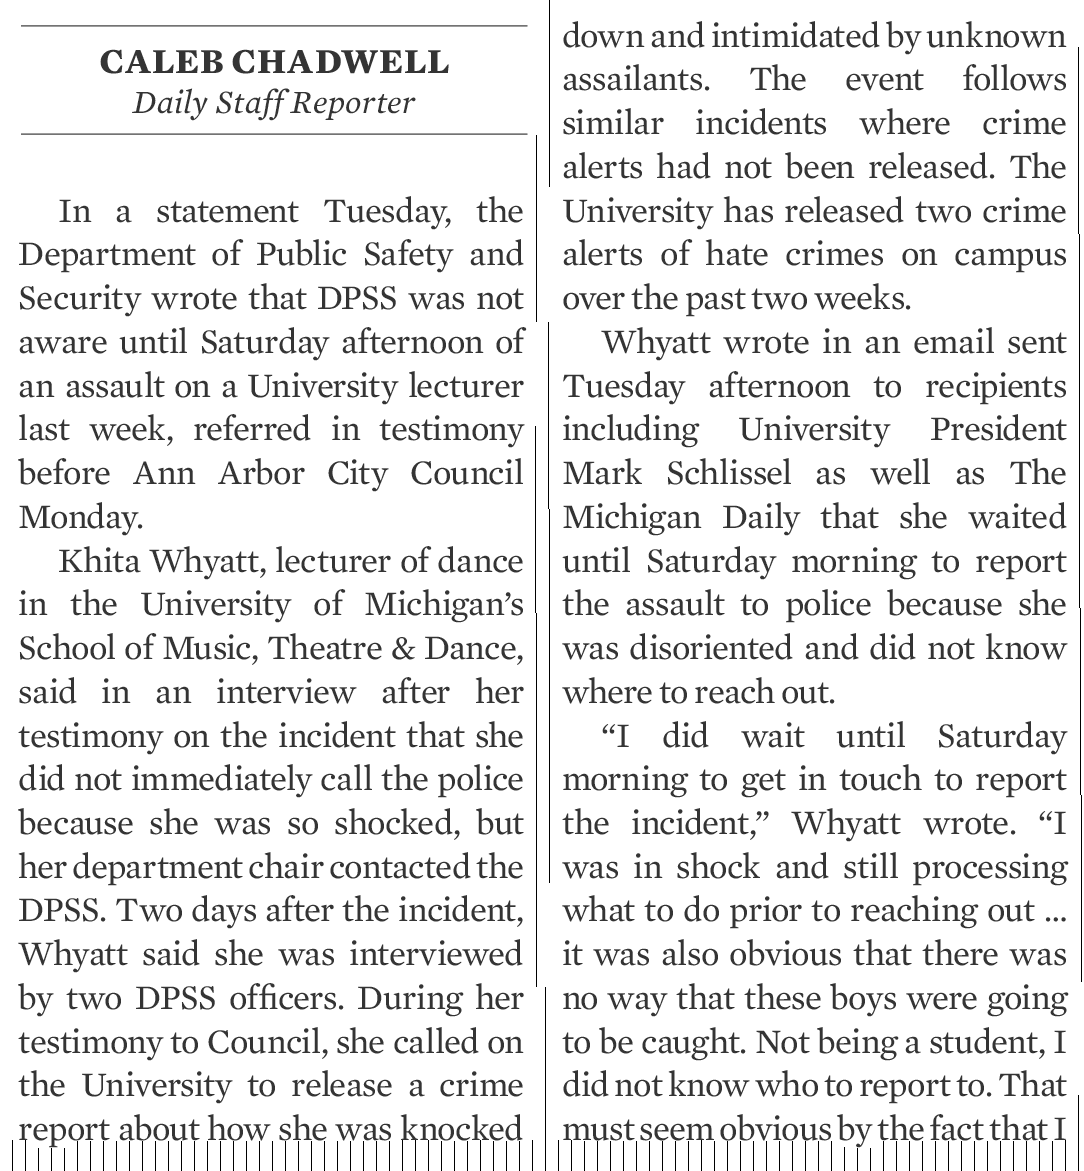

In [18]:
# Now, lets try it all out. This is pretty easy, we can just iterate through each pixel 
# in the image, check if there is a gap, then insert a line if there is.
def process_image(img):
    '''Takes in an image of text and adds black vertical bars to break up columns
    :param img: A PIL.Image file
    :return: A modified PIL.Image file
    '''
    # we'll start with a familiar iteration process
    for x in range(img.width):
        for y in range(img.height):
            # check if there is a gap at this point
            if (gap_check(img, (x,y))):
                # then update image to one which has a separator drawn on it
                draw_sep(img, (x,y))
    # and for good measure we'll return the image we modified
    return img

# Lets read in our test image and convert it through binarization
i=Image.open("readonly/two_col.png").convert("L")
i=process_image(i)
display(i)

#Note: This will take some time to run! Be patient!

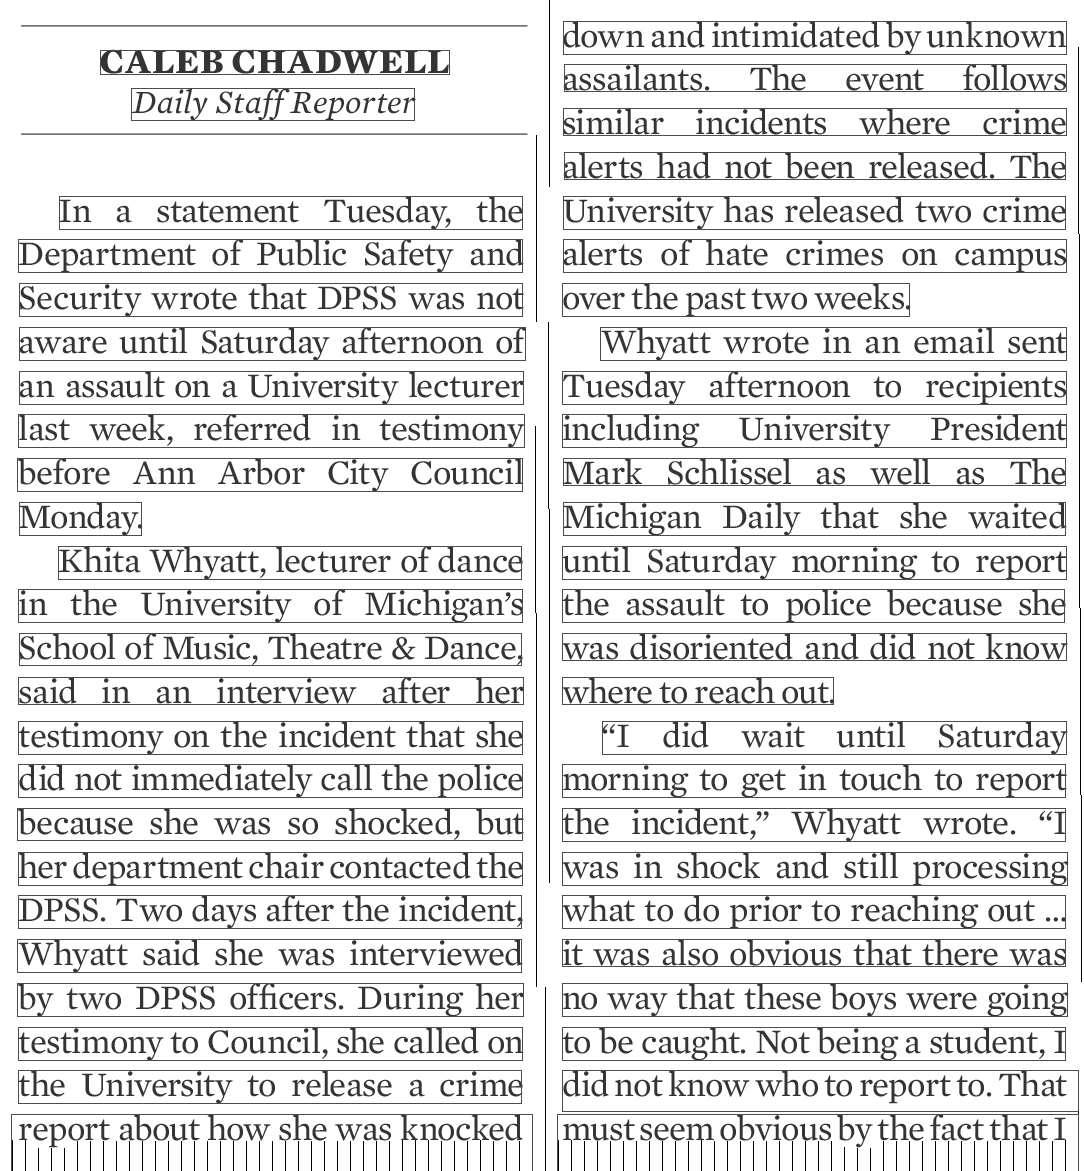

In [12]:
# Not bad at all! The effect at the bottom of the image is a bit unexpected to me, but it makes
# sense. You can imagine that there are several ways we might try and control this. Lets see how 
# this new image works when run through the kraken layout engine
display(show_boxes(i))

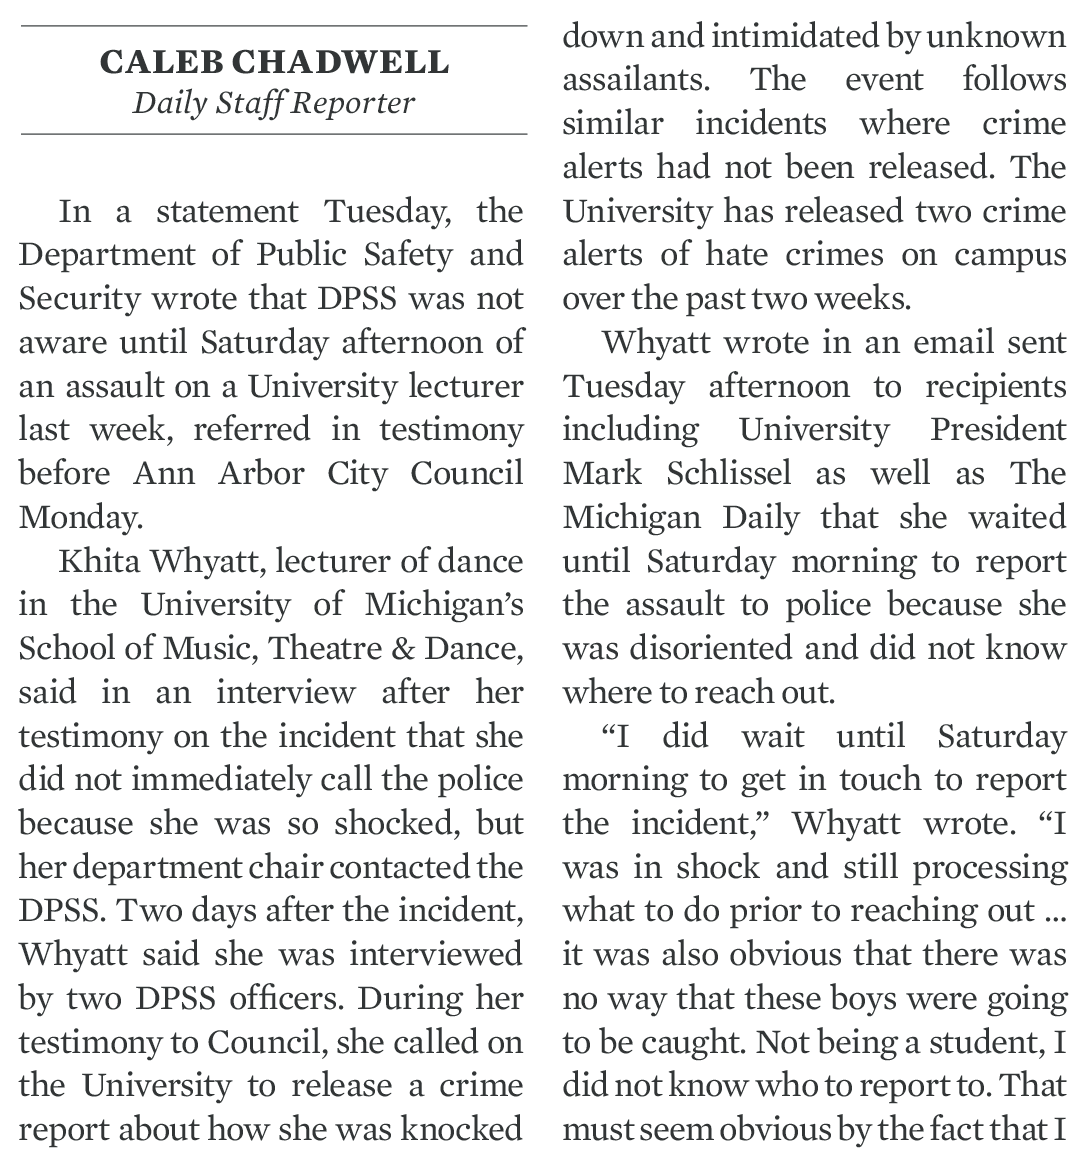

(1084, 1171)


In [20]:
# I wonder if it could be easier for kraken if the two column post was split into two images left and right?
from PIL import Image
im=Image.open("readonly/two_col.png")
# Lets display the image inline
display(im)
print(im.size)

In [21]:
im=Image.open("readonly/two_col.png")
width, height = im.size
print(width, height)

1084 1171


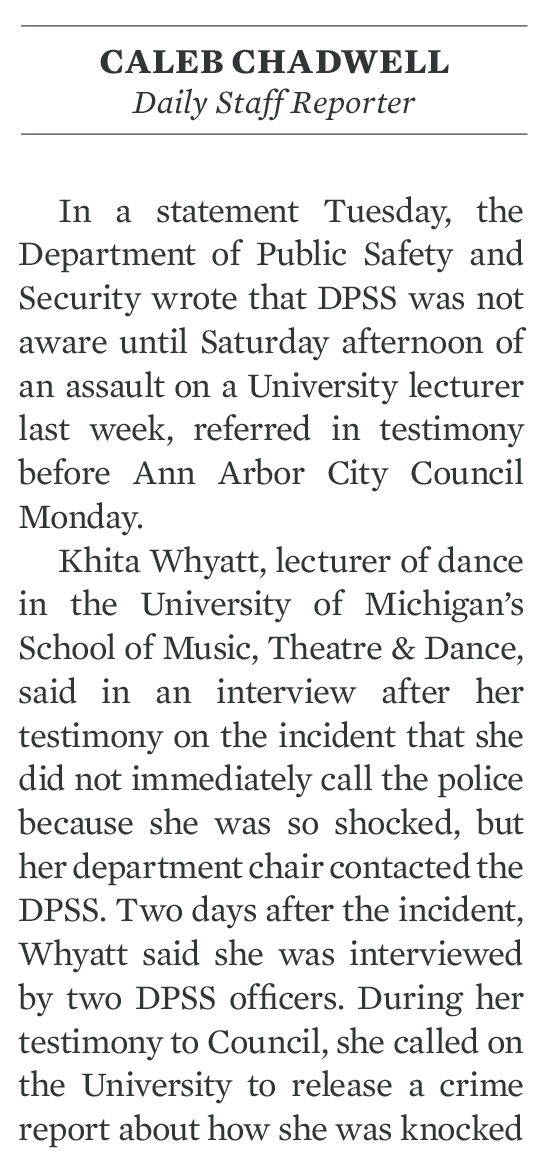

In [22]:
left_box = (0,0,width/2,height)
right_box = (width/2, 0, width, height)
left_crop = im.crop((left_box))
right_crop = im.crop((right_box))
# display(show_boxes(left_crop)) 
# print("------------------------")
# display(show_boxes(right_crop))
display(left_crop)

Total boxes in the left half is  24


CALEKBCHADWELL


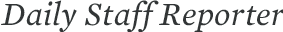

Daily Staff Reporter


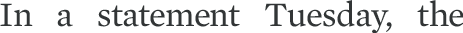

In a statement Tuesday, the


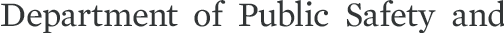

Department of Public Safety and


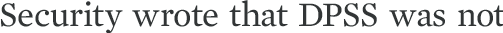

Security wrote that DPSS was not


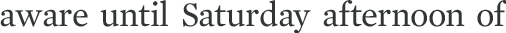

aware until Saturday afternoon of


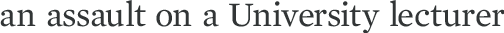

an assault on a University lecturer


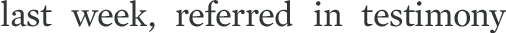

last week, referred in testimony


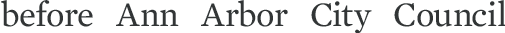

before Ann Arbor City Council


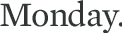

Monday.


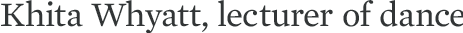

Khita Whyatt, lecturer of dance


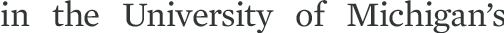

in the University of Michigan’s


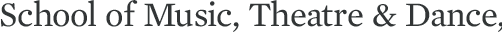

School of Music, Theatre & Dance,


said in an interview atter her


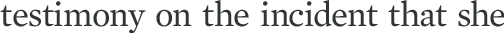

testimony on the incident that she


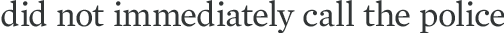

did not immediately call the police


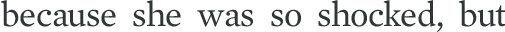

because she was so shocked, but


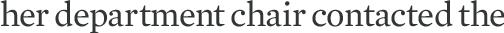

her department chair contacted the


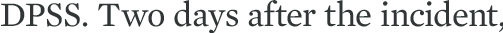

DPSS. Two days after the incident,


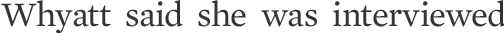

Whyatt said she was interviewed


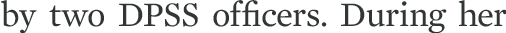

by two DPSS officers. During her


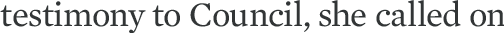

testimony to Council, she called on


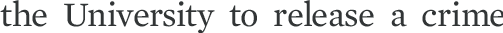

the University to release a crime


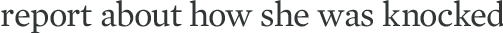

report about how she was knocked


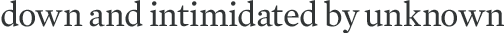

down and intimidated by unknown


assailants. The event § ftollows


similar incidents where crime


alerts had not been released. The


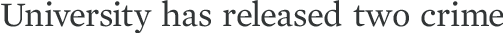

University has released two crime


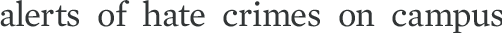

alerts of hate crimes on campus


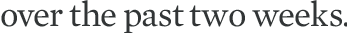

over the past two weeks.


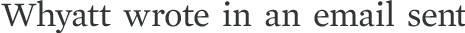

Whyatt wrote in an email sent


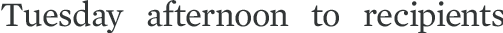

Tuesday afternoon to recipients


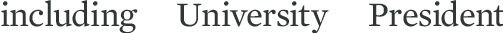

including University President


Mark Schlissel as well as The


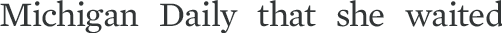

Michigan Daily that she waited


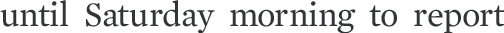

until Saturday morning to report


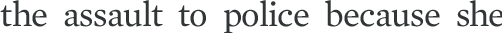

the assault to police because she


was disoriented and did not know


where to reach out.


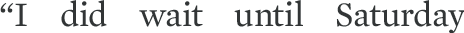

“IT did wait until Saturday


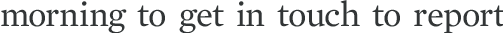

morning to get in touch to report


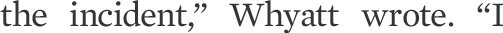

the incident,’ Whyatt wrote. “I


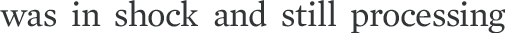

was in shock and still processing


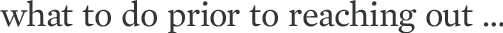

what to do prior to reaching out ...


it was also obvious that there was


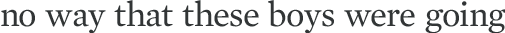

no way that these boys were going


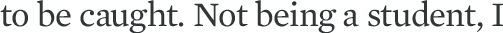

to be caught. Not being a student, I


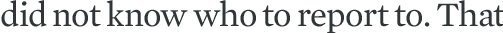

did not know who to report to. That


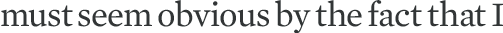

must seem obvious by the fact that I


In [23]:
import pytesseract
import numpy as np
im=Image.open("readonly/two_col.png")

left_boxes = pageseg.segment(left_crop.convert('1'))['boxes']
right_boxes=pageseg.segment(right_crop.convert('1'))['boxes']

print("Total boxes in the left half is ", len(left_boxes))

# for box in left_boxes:
#     target = im.crop(box)
#     display(target)
#     print(pytesseract.image_to_string(target))

#good stackoverflow link: 
# https://stackoverflow.com/questions/54261255/pytesseract-cant-read-text-off-very-simple-image

def box2dict(box_list, image):
    '''return a dict int:[img, text] from sub-images defined by box list'''
    ret_dict = {}
    counter = 1
    for box in box_list:
        target = image.crop(box)
        ret_val = pytesseract.image_to_string(target, lang='eng', config='--psm 7')
        ret_dict[counter] = [target, ret_val]
        counter += 1
    
    return ret_dict
        
        
left_dict = box2dict(left_boxes, left_crop)
right_dict = box2dict(right_boxes, right_crop)

# for box in right_boxes:
#     target = right_crop.crop(box)
#     display(target)
#     ret_val = pytesseract.image_to_string(target, lang='eng', config='--psm 7')
#     print("ret val is:", ret_val)
    
#     if len(ret_val) < 3:
        
#         print("EXCEPTION_______EXCEPTION")
        
#         exception_boxes=pageseg.segment(target.convert('1'))['boxes']
#         for eb in exception_boxes:
#             e_target = target.crop(eb)
#             display(e_target)
#             im2arr = np.array(e_target) # im2arr.shape: height x width x channel
#             #arr2im = Image.fromarray(im2arr)
#             print(im2arr.shape)



for x in left_dict.values():
    display(x[0])
    print(x[1])
    
for x in right_dict.values():
    display(x[0])
    print(x[1])

In [25]:
# OpenCV supports reading of images in most file formats, such as JPEG, PNG, and TIFF. Most image and 
# video analysis requires converting images into grayscale first. This simplifies the image and reduces 
# noise allowing for improved analysis. Let's write some code that reads an image of as person, Floyd 
# Mayweather and converts it into greyscale.

# First we will import the open cv package cv2 
import cv2 as cv
# We'll load the floyd.jpg image 
img = cv.imread('readonly/floyd.jpg')
# And we'll convert it to grayscale using the cvtColor image
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Now, before we get to the result, lets talk about docs. Just like tesseract, opencv is an external
# package written in C++, and the docs for python are really poor. This is unfortunatly quite common
# when python is being used as a wrapper. Thankfully, the web docs for opencv are actually pretty good,
# so hit the website docs.opencv.org when you want to learn more about a particular function. In this
# case cvtColor converts from one color space to another, and we are convering our image to grayscale.
# Of course, we already know at least two different ways of doing this, using binarization and PIL
# color spaces conversions

# Lets instpec this object that has been returned.
import inspect
inspect.getmro(type(gray))

(numpy.ndarray, object)

In [27]:
# We see that it is of type ndarray, which is a fundamental list type coming from the numerical
# python project. That's a bit surprising - up until this point we have been used to working with
# PIL.Image objects. OpenCV, however, wants to represent an image as a two dimensional sequence 
# of bytes, and the ndarray, which stands for n dimensional array, is the ideal way to do this.
# Lets look at the array contents.
gray

array([[ 40,  39,  39, ...,  77,  76,  75],
       [ 43,  42,  42, ...,  76,  75,  75],
       [ 39,  39,  39, ...,  76,  75,  74],
       ...,
       [ 21,  22,  24, ..., 219, 223, 209],
       [ 18,  20,  22, ..., 196, 206, 196],
       [ 16,  18,  20, ..., 168, 182, 176]], dtype=uint8)

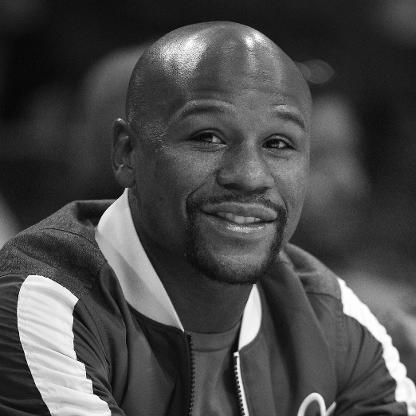

In [26]:
# The array is shown here as a list of lists, where the inner lists are filled with integers.
# The dtype=uint8 definition indicates that each of the items in an array is an 8 bit unsigned
# integer, which is very common for black and white images. So this is a pixel by pixel definition
# of the image.
#
# The display package, however, doesn't know what to do with this image. So lets convert it
# into a PIL object to render it in the browser.
from PIL import Image

# PIL can take an array of data with a given color format and convert this into a PIL object.
# This is perfect for our situation, as the PIL color mode, "L" is just an array of luminance
# values in unsigned integers
image = Image.fromarray(gray, "L")
display(image)

In [28]:
# Lets talk a bit more about images for a moment. Numpy arrays are multidimensional. For 
# instance, we can define an array in a single dimension:
import numpy as np
single_dim = np.array([25, 50 , 25, 10, 10])

# In an image, this is analagous to a single row of 5 pixels each in grayscale. But actually,
# all imaging libraries tend to expect at least two dimensions, a width and a height, and to
# show a matrix. So if we put the single_dim inside of another array, this would be a two
# dimensional array with element in the height direction, and five in the width direction
double_dim = np.array([single_dim])

double_dim

array([[25, 50, 25, 10, 10]])

In [29]:
# This should look pretty familiar, it's a lot like a list of lists! Lets see what this new
# two dimensional array looks like if we display it
display(Image.fromarray(double_dim, "L"))

In [30]:
# Lets take a look at the shape of our initial image which we loaded into the img variable
img.shape

(416, 416, 3)

In [31]:
# This image has three dimensions! That's because it has a width, a height, and what's called
# a color depth. In this case, the color is represented as an array of three values. Lets take a 
# look at the color of the first pixel
first_pixel=img[0][0]
first_pixel

array([33, 35, 53], dtype=uint8)

# Open CV

In [32]:
# Ok, we're just about at the project for this course. If you reflect on the specialization 
# as a whole you'll realize that you started with probably little or no understanding of python,
# progressed through the basic control structures and libraries included with the language
# with the help of a digital textbook, moved on to more high level representations of data
# and functions with objects, and now started to explore third party libraries that exist for
# python which allow you to manipulate and display images. This is quite an achievement!
#
# You have also no doubt found that as you have progressed the demands on you to engage in self-
# discovery have also increased. Where the first assignments were maybe straight forward, the
# ones in this week require you to struggle a bit more with planning and debugging code as
# you develop.
#
# But, you've persisted, and I'd like to share with you just one more set of features before
# we head over to a project. The OpenCV library contains mechanisms to do face detection on
# images. The technique used is based on Haar cascades, which is a machine learning approach.
# Now, we're not going to go into the machine learning bits, we have another specialization on
# Applied Data Science with Python which you can take after this if you're interested in that topic.
# But here we'll treat OpenCV like a black box.
#
# OpenCV comes with trained models for detecting faces, eyes, and smiles which we'll be using.
# You can train models for detecting other things - like hot dogs or flutes - and if you're
# interested in that I'd recommend you check out the Open CV docs on how to train a cascade
# classifier: https://docs.opencv.org/3.4/dc/d88/tutorial_traincascade.html
# However, in this lecture we just want to use the current classifiers and see if we can detect
# portions of an image which are interesting.
#
# First step is to load opencv and the XML-based classifiers
import cv2 as cv
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('readonly/haarcascade_eye.xml')

In [33]:
# Ok, with the classifiers loaded, we now want to try and detect a face. Lets pull in the
# picture we played with last time
img = cv.imread('readonly/floyd.jpg')
# And we'll convert it to grayscale using the cvtColor image
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# The next step is to use the face_cascade classifier. I'll let you go explore the docs if you
# would like to, but the norm is to use the detectMultiScale() function. This function returns
# a list of objects as rectangles. The first parameter is an ndarray of the image.
faces = face_cascade.detectMultiScale(gray)
# And lets just print those faces out to the screen
faces

array([[158,  75, 176, 176]], dtype=int32)

In [34]:
faces.tolist()[0]

[158, 75, 176, 176]

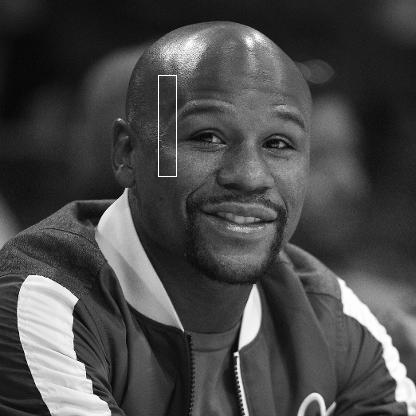

In [37]:
# The resulting rectangles are in the format of (x,y,w,h) where x and y denote the upper
# left hand point for the image and the width and height represent the bounding box. We know
# how to handle this in PIL
from PIL import Image

# Lets create a PIL image object
pil_img=Image.fromarray(gray,mode="L")

# Now lets bring in our drawing object
from PIL import ImageDraw
# And lets create our drawing context
drawing=ImageDraw.Draw(pil_img)

# Now lets pull the rectangle out of the faces object
rec=faces.tolist()[0]

# Now we just draw a rectangle around the bounds
drawing.rectangle(rec, outline="white")

# And display
display(pil_img)

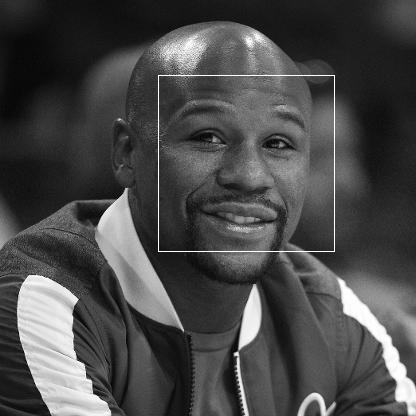

In [38]:
# So, not quite what we were looking for. What do you think went wrong?
# Well, a quick double check of the docs and it is apparent that OpenCV is return the coordinates
# as (x,y,w,h), while PIL.ImageDraw is looking for (x1,y1,x2,y2). Looks like an easy fix
# Wipe our old image
pil_img=Image.fromarray(gray,mode="L")
# Setup our drawing context
drawing=ImageDraw.Draw(pil_img)
# And draw the new box
drawing.rectangle((rec[0],rec[1],rec[0]+rec[2],rec[1]+rec[3]), outline="white")
# And display
display(pil_img)

In [39]:
# We see the face detection works pretty good on this image! Note that it's apparent that this is
# not head detection, but that the haarcascades file we used is looking for eyes and a mouth.
# Lets try this on something a bit more complex, lets read in our MSI recruitment image
img = cv.imread('readonly/msi_recruitment.gif')
# And lets take a look at that image
display(Image.fromarray(img))

AttributeError: 'NoneType' object has no attribute '__array_interface__'

In [42]:
# Whoa, what's that error about? It looks like there is an error on a line deep within the PIL
# Image.py file, and it is trying to call an internal private member called __array_interface__
# on the img object, but this object is None
#
# It turns out that the root of this error is that OpenCV can't work with Gif images. This is
# kind of a pain and unfortunate. But we know how to fix that right? One was is that we could
# just open this in PIL and then save it as a png, then open that in open cv.
#
# Lets use PIL to open our image
pil_img=Image.open('readonly/msi_recruitment.gif')
# now lets convert it to greyscale for opencv, and get the bytestream
open_cv_version=pil_img.convert("L")
# now lets just write that to a file
open_cv_version.save("msi_recruitment.png")

FileNotFoundError: [Errno 2] No such file or directory: 'readonly/msi_recruitment.gif'